## Import Libaries

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import pytz
import plotly.express as px
import seaborn as sns

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA 
from sklearn.metrics import mean_absolute_error 

import time


import warnings
warnings.filterwarnings('ignore')

## Create a Wrangle Function that cleans the dataset

In [4]:
def wrangle(path, time_zone = 'Asia/Kolkata'):
    # read file into environment
    df = pd.read_csv(path)
    # # Drop redundant columns
    df.drop(columns = ['Year', 'Month', 'Day', 'Hour'], inplace =True)
    # # change "Timestamp" column to datatime dtype
    df['Timestamp'] = pd.to_datetime(df['Timestamp'])
    # # set datetime as index
    df = df.set_index('Timestamp')
    # # localize Timezone
    df.index = df.index.tz_localize('UTC').tz_convert(time_zone)
    # Resample timeseries from hourly to daily
    y = df['PM2.5'].resample('D').mean().fillna(method = 'ffill')
    


    return y

## Import Data

In [6]:
y = wrangle('data/air-quality-india-data.csv')
y.head()

Timestamp
2017-11-07 00:00:00+05:30    100.152857
2017-11-08 00:00:00+05:30    105.876957
2017-11-09 00:00:00+05:30    114.665000
2017-11-10 00:00:00+05:30    118.872609
2017-11-11 00:00:00+05:30    109.895000
Freq: D, Name: PM2.5, dtype: float64

In [7]:
# check data type

In [8]:
# set timestamp to index

In [9]:
# localize timezone

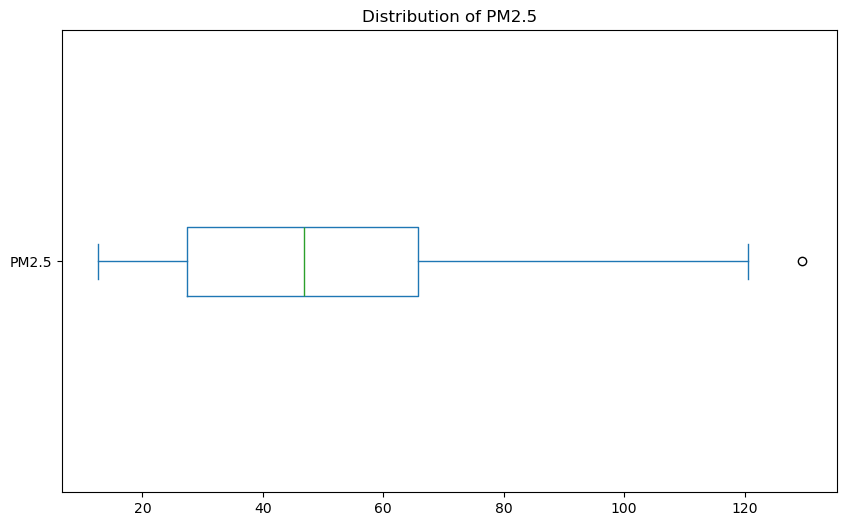

In [10]:
# check PM2.5 distribution for possible outliers
fig, ax = plt.subplots (figsize = (10, 6))
y.plot(kind = 'box', vert = False, ax = ax , title = 'Distribution of PM2.5');

In [11]:
y.describe().T

count    1671.000000
mean       48.784219
std        23.340559
min        12.560000
25%        27.412482
50%        46.845000
75%        65.707708
max       129.530909
Name: PM2.5, dtype: float64

In [12]:
# There are no outliers, the PM2.5 reading ranges from 20 to about 600 in India

In [13]:
# Data is collected from november 2017 to June 2022

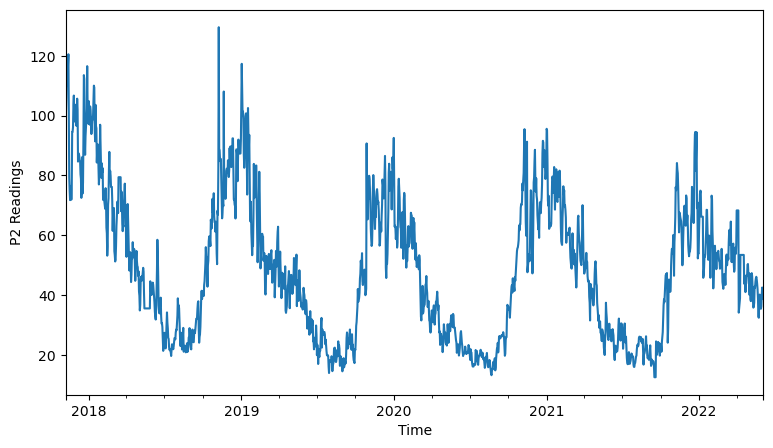

In [14]:
#  plot timeseries
fig, ax = plt.subplots(figsize = (9, 5))
y.plot(ylabel ='P2 Readings', xlabel = 'Time', ax = ax);

Timeseries is non-stationary(seasonal), repeating pattern, we will carry out more test to validate this observation

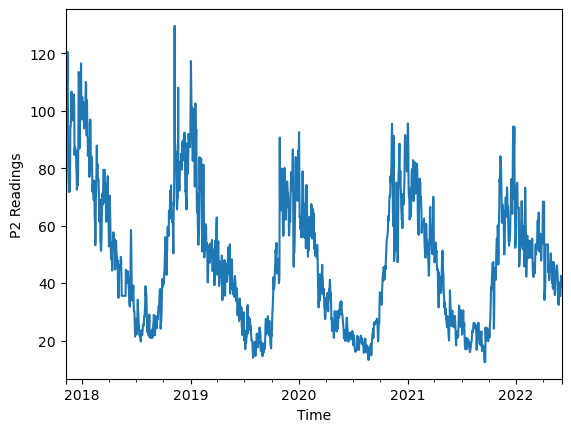

In [16]:
# predict daily instead of hourly
y.resample('D').mean().plot(ylabel = 'P2 Readings', xlabel ='Time');

In [17]:
y.index.freq

<Day>

In [18]:
# we have 54 Nans after resampling

# EDA

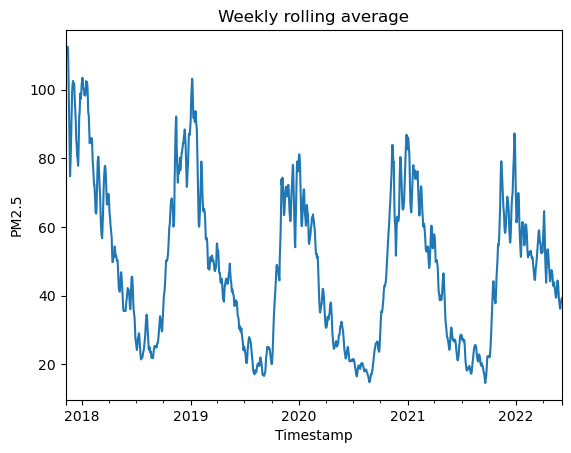

In [20]:
# Rolling Average
y.rolling(7).mean().plot(ylabel = 'PM2.5', title = 'Weekly rolling average');

### Stationary check

In [22]:
# Augumented Dickey-Fuller test to see if time is truly non-stationary
adftest = adfuller(y)[1]
print('Pvalue of adfuller test is', adftest)

Pvalue of adfuller test is 0.0843538685731427


Pvalue higher than 0.05 indicates that this is non-stationary

In [24]:
# make it stationary by differencing
differenced  = y.diff(12).dropna()

In [25]:
differenced.isna().sum()

0

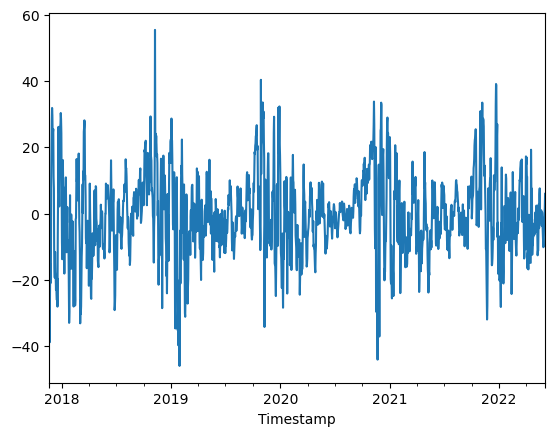

In [26]:
differenced.plot();

In [27]:
adfuller(differenced)[1]

1.5719510131478528e-07

Stationary is achieved

In [29]:
# plot_acf(y.diff(12).dropna())

In [30]:
# More exploration

In [31]:
# plot Acf

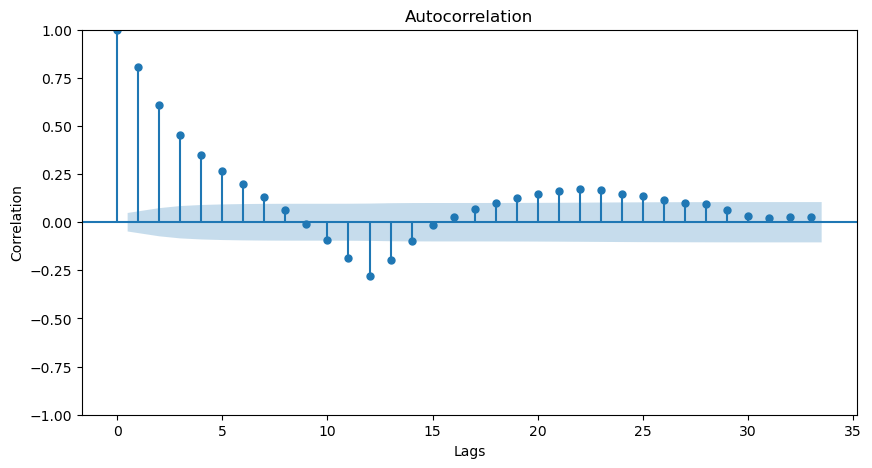

In [32]:
fig, ax = plt.subplots(figsize = (10, 5))
plot_acf(differenced, ax = ax)
plt.xlabel('Lags')
plt.ylabel('Correlation');

In [33]:
# Plot Pacf

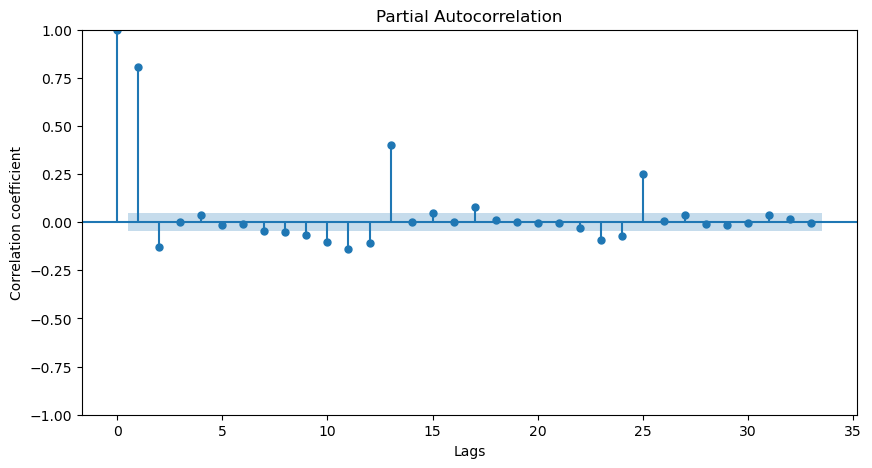

In [34]:
fig, ax = plt.subplots(figsize = (10, 5))
plot_pacf(differenced, ax = ax)
plt.xlabel('Lags')
plt.ylabel('Correlation coefficient');

- Significant correlation until 25 Lags

## Cut-off Split

In [37]:
cutoff = int(len(y) * 0.2)
y_train = y.iloc[:cutoff]
y_test = y.iloc[cutoff:]

In [38]:
len(y_train + y_test) == len(y)

True

# Build Baseline Model

In [40]:
y_train_mean = y_train.mean()
y_pred_baseline = [y_train_mean] * len(y_train)
mae_baseline = mean_absolute_error(y_train ,y_pred_baseline)
print('Mean PM2.5 is', round(y_train.mean(), 2))
print('Baseline Mean absolute error is', round(mae_baseline, 2))

Mean PM2.5 is 56.67
Baseline Mean absolute error is 24.46


#### Observation
- If we predict 56.67 every time for PM2.5 value, we will be off by 24.46 MAE

# Build Model

In [42]:
# Build ARIMA model and choose best Order

In [43]:
p_params = range(1, 26)
q_params = range(1, 3, 1)

In [44]:
#  Hyperparameter Tuning

In [45]:
# create dictionary to store MAEs
mae_grid = dict()
# Loop through possible p values
for p in p_params:
    #create key-value pair in dict
    mae_grid[p]= []
    # Loop through possible q values
    for q in q_params:
        # combinations of p and q for model
        order = (p, 1, q)
        # start time of model
        start_time = time.time()
        model = ARIMA(y_train, order = order).fit()
        # elapsed time of model to train
        time_taken = round(time.time() - start_time)
        print(f'model{order} trained in {time_taken} secs')
        y_pred = model.predict()
        mae = mean_absolute_error(y_train, y_pred)
        print(round(mae, 2))
        # append MAE to lists in dictionary
        mae_grid[p].append(mae)

model(1, 1, 1) trained in 0 secs
3.93
model(1, 1, 2) trained in 0 secs
3.93
model(2, 1, 1) trained in 0 secs
3.92
model(2, 1, 2) trained in 0 secs
3.92
model(3, 1, 1) trained in 0 secs
3.89
model(3, 1, 2) trained in 0 secs
3.92
model(4, 1, 1) trained in 0 secs
3.89
model(4, 1, 2) trained in 0 secs
3.91
model(5, 1, 1) trained in 0 secs
3.91
model(5, 1, 2) trained in 0 secs
3.84
model(6, 1, 1) trained in 0 secs
3.9
model(6, 1, 2) trained in 0 secs
3.9
model(7, 1, 1) trained in 0 secs
3.9
model(7, 1, 2) trained in 0 secs
3.9
model(8, 1, 1) trained in 0 secs
3.87
model(8, 1, 2) trained in 0 secs
3.9
model(9, 1, 1) trained in 0 secs
3.87
model(9, 1, 2) trained in 0 secs
3.9
model(10, 1, 1) trained in 0 secs
3.87
model(10, 1, 2) trained in 1 secs
3.87
model(11, 1, 1) trained in 0 secs
3.88
model(11, 1, 2) trained in 1 secs
3.87
model(12, 1, 1) trained in 0 secs
3.88
model(12, 1, 2) trained in 1 secs
3.87
model(13, 1, 1) trained in 1 secs
3.88
model(13, 1, 2) trained in 1 secs
3.82
model(14, 

#### Observation

- 3.76 training MAE which beats the baseline MAE by a distance. now we check if test MAE will also do better

In [46]:
# put mae_grid in Dataframe
mae_df = pd.DataFrame(mae_grid, index = [1,2])
mae_df.round(2)

,1,2,3,4,5,6,7,8,9,10,...,16,17,18,19,20,21,22,23,24,25
1,3.93,3.92,3.89,3.89,3.91,3.9,3.9,3.87,3.87,3.87,...,3.85,3.85,3.86,3.84,3.82,3.82,3.78,3.78,3.76,3.77
2,3.93,3.92,3.92,3.91,3.84,3.9,3.9,3.90,3.90,3.87,...,3.80,3.86,3.80,3.81,3.81,3.82,3.77,3.78,3.76,3.76


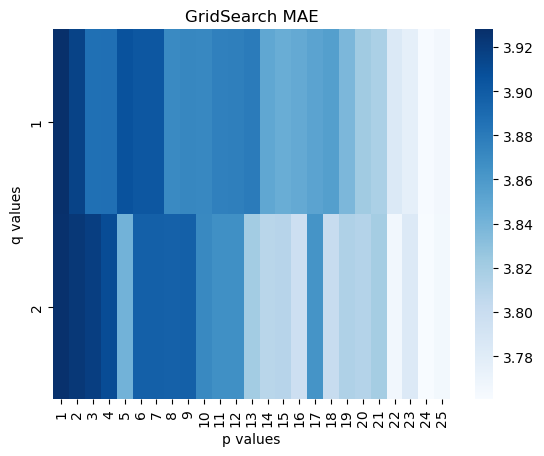

In [47]:
#  visualize MAE for each combination
sns.heatmap(mae_df, cmap = 'Blues')
plt.xlabel('p values')
plt.ylabel('q values')
plt.title('GridSearch MAE');

#### Observation
- p at 25 and q at 2 is the best hyperparameter combination

In [211]:
# Best Model
best_param = (25, 1, 2)

In [ ]:
# Best Model
best_model= ARIMA(y_train, order = best_model).fit()

### Quantify Train Performance using Plots

In [213]:
# Extract Residuals from Best model
residual = best_model.resid

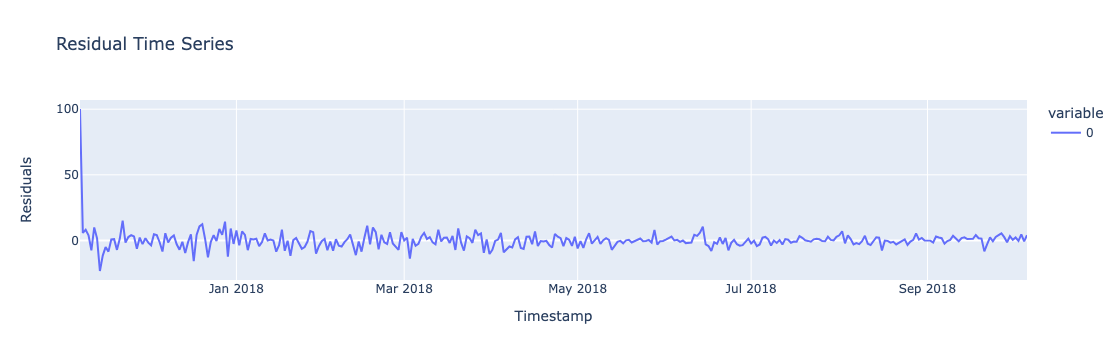

In [227]:
# Plot Time Series of Residuals
px.line(residual, labels ={'value': 'Residuals', 'index': 'Timestamp'}, title = 'Residual Time Series')

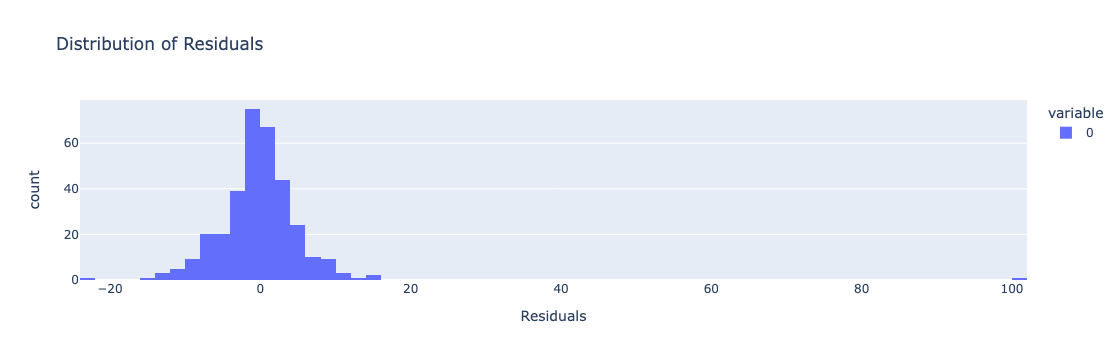

In [229]:
# Plot Histogram
px.histogram(residual, labels = {'value': 'Residuals'}, title = 'Distribution of Residuals')

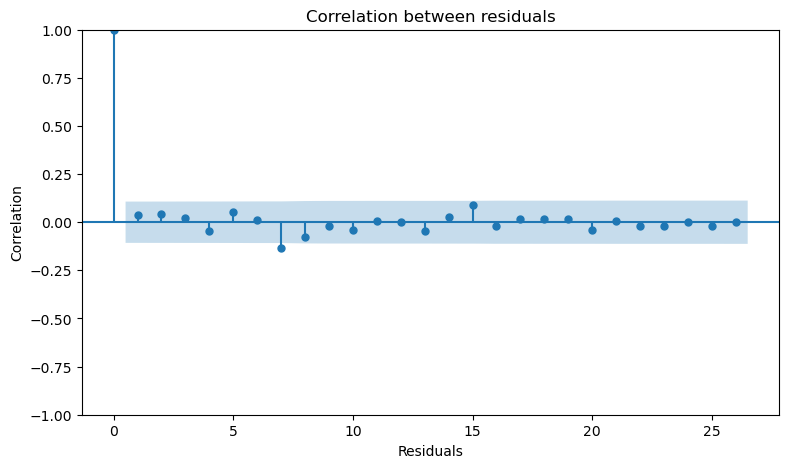

In [233]:
# Plot ACF for Residuals
fig, ax = plt.subplots(figsize = (9, 5))
plot_acf(residual, ax = ax)
plt.xlabel('Residuals')
plt.ylabel('Correlation')
plt.title('Correlation between residuals');

#### Observations from plots; top to bottom
- residuals is static i.e it shows no trend in time series plot
- residuals are normally distributed
- residuals has no correlation, meaning model has extracted all possible information from the data

All these signifies that our train accuracy is ok, these are desired observations

# Evaluate Test Accuracy

In [58]:
# create y_pred to store predictions
y_pred_wfv = []
# where to add y_tests
history = list(y_train.copy())
for i in range(len(y_test)):
    # instantiate and train best model
    model = ARIMA(history, order = (2, 1, 2)).fit()
    # predict next value
    nxt_pred = model.forecast()[0]
    # append predicted value
    y_pred_wfv.append(nxt_pred)
    #add next y_test value to y_train(history) after every prediction
    history.append(y_test.iloc[i])

In [68]:
y_pred_wfv = pd.Series(y_pred_wfv, index = y_test.index)

In [78]:
# check test_accuracy
test_mae = mean_absolute_error(y_test, y_pred_wfv)
print('Test MAE is', test_mae)

Test MAE is 3.5281778388101444


# Communicate Result

In [239]:
y_pred_df = pd.DataFrame(
    {'y_test' : y_test, 'y_pred_wfv': y_pred_wfv}
)

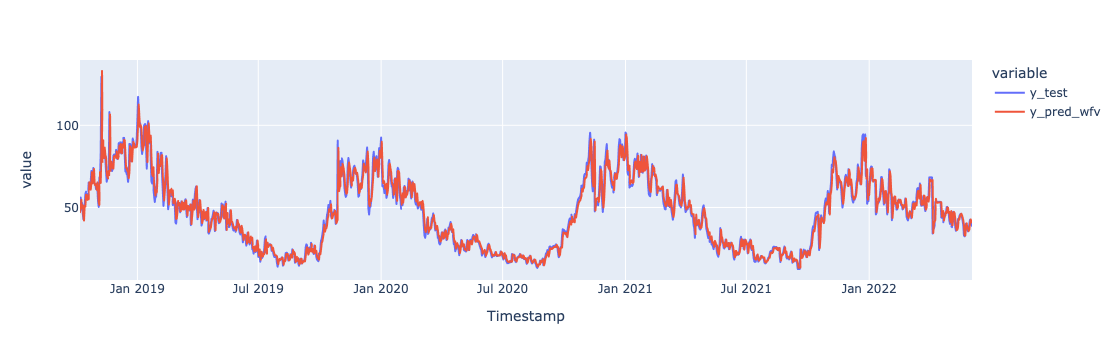

In [243]:
fig = px.line(y_pred_df, labels ={'va;'})
fig.show()

# Save Model

In [258]:
import pickle
with open('models/arima.pkl', 'wb') as file:
    pickle.dump(best_model, file)